In [3]:
import pandas as pd
import numpy as np
from scipy.stats import entropy
import sys,pickle,glob
from tqdm import tqdm_notebook as tq
from IPython.display import display
from nltk.corpus import stopwords
from nltk.stem.snowball import EnglishStemmer
from collections import Counter
from IPython.core.display import display
#from pathos import multiprocessing as mp

from matplotlib import pyplot as plt
import seaborn
colors = seaborn.color_palette()
xr_full = range(1991,2016)
xr = range(1992,2016)
%matplotlib inline

In [15]:
DATADIR = '../results/'
#DATADIR = '/Users/jaredlorince/Desktop/'
# files = glob.glob(DATADIR+'by-cat-results/results*')
# cats = set([f[f.rfind('_')+1:] for f in files])
# print(sorted(cats))

In [81]:
cat_citations_by_year

,Acoustics,Agricultural Economics & Policy,Agricultural Engineering,"Agriculture, Dairy & Animal Science","Agriculture, Multidisciplinary",Agronomy,Allergy,Anatomy & Morphology,Andrology,Anesthesiology,...,Transportation Science & Technology,Tropical Medicine,Urban Studies,Urology & Nephrology,Veterinary Sciences,Virology,Water Resources,Women's Studies,Zoology,ALL
1991,233.0,12.0,40.0,506.0,245.0,521.0,131.0,114.0,19.0,435.0,...,25.0,136.0,73.0,451.0,785.0,1006.0,241.0,39.0,1067.0,165766
1992,926.0,93.0,213.0,1615.0,895.0,1821.0,792.0,680.0,109.0,1729.0,...,73.0,620.0,142.0,2303.0,2681.0,3686.0,1794.0,134.0,4031.0,974242
1993,1833.0,230.0,430.0,3096.0,1687.0,3713.0,1582.0,1458.0,262.0,3433.0,...,146.0,1248.0,403.0,5043.0,5421.0,6680.0,3093.0,257.0,7701.0,2155342
1994,2854.0,330.0,676.0,4410.0,2404.0,5350.0,2586.0,2179.0,411.0,5173.0,...,249.0,1909.0,559.0,8141.0,8176.0,9848.0,4505.0,403.0,11230.0,3459757
1995,3902.0,496.0,921.0,5922.0,3384.0,7631.0,3650.0,2957.0,546.0,7364.0,...,372.0,2544.0,876.0,12080.0,11367.0,13102.0,6033.0,635.0,14958.0,4760754
1996,5550.0,647.0,1209.0,7573.0,4521.0,10324.0,5072.0,3612.0,648.0,9911.0,...,543.0,3343.0,1203.0,17299.0,15802.0,16192.0,8008.0,812.0,19458.0,6319908
1997,6674.0,741.0,1482.0,9425.0,5508.0,12487.0,6315.0,4220.0,813.0,12017.0,...,723.0,4065.0,1616.0,21073.0,19704.0,18959.0,9924.0,1051.0,23152.0,7502295
1998,7901.0,876.0,1873.0,11503.0,6620.0,14113.0,7371.0,5004.0,950.0,14305.0,...,946.0,4731.0,1897.0,25166.0,23091.0,21947.0,12201.0,1275.0,26884.0,8751910
1999,8917.0,1041.0,2239.0,12827.0,7654.0,15868.0,8426.0,5473.0,1144.0,15751.0,...,980.0,5466.0,2227.0,28788.0,26290.0,24934.0,14348.0,1577.0,30299.0,9913144
2000,10212.0,1091.0,2354.0,14241.0,8880.0,17723.0,9614.0,6219.0,1287.0,17335.0,...,1345.0,6097.0,2674.0,32803.0,29915.0,27439.0,15410.0,1897.0,33768.0,11082698


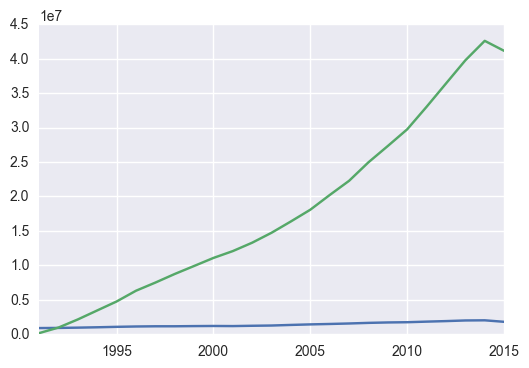

In [79]:
cat_pubs_by_year['ALL'].plot()
cat_citations_by_year['ALL'].plot()

In [38]:
cat_pubs_by_year = pd.read_pickle(DATADIR+'cat_pubs_by_year.pkl')
cat_citations_by_year = pd.read_pickle(DATADIR+'cat_citations_by_year.pkl')
cat_authors_by_year = pd.read_pickle(DATADIR+'cat_authors_by_year.pkl')

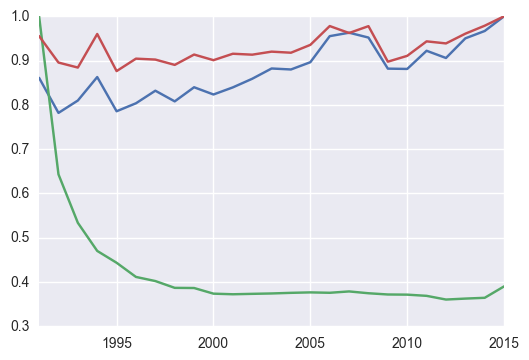

In [88]:
cat =  'Physics, Applied'
p = (cat_pubs_by_year[cat] / cat_pubs_by_year['ALL'])
(p/p.max()).plot()
c = (cat_citations_by_year[cat] / cat_citations_by_year['ALL'])
(c/c.max()).plot()
a = (cat_authors_by_year[cat] / cat_authors_by_year['ALL'])
(a/a.max()).plot()


In [6]:
props = cat_pubs_by_year.divide(cat_pubs_by_year['ALL'],axis=0)
growth = np.log10(props/props.shift(1))

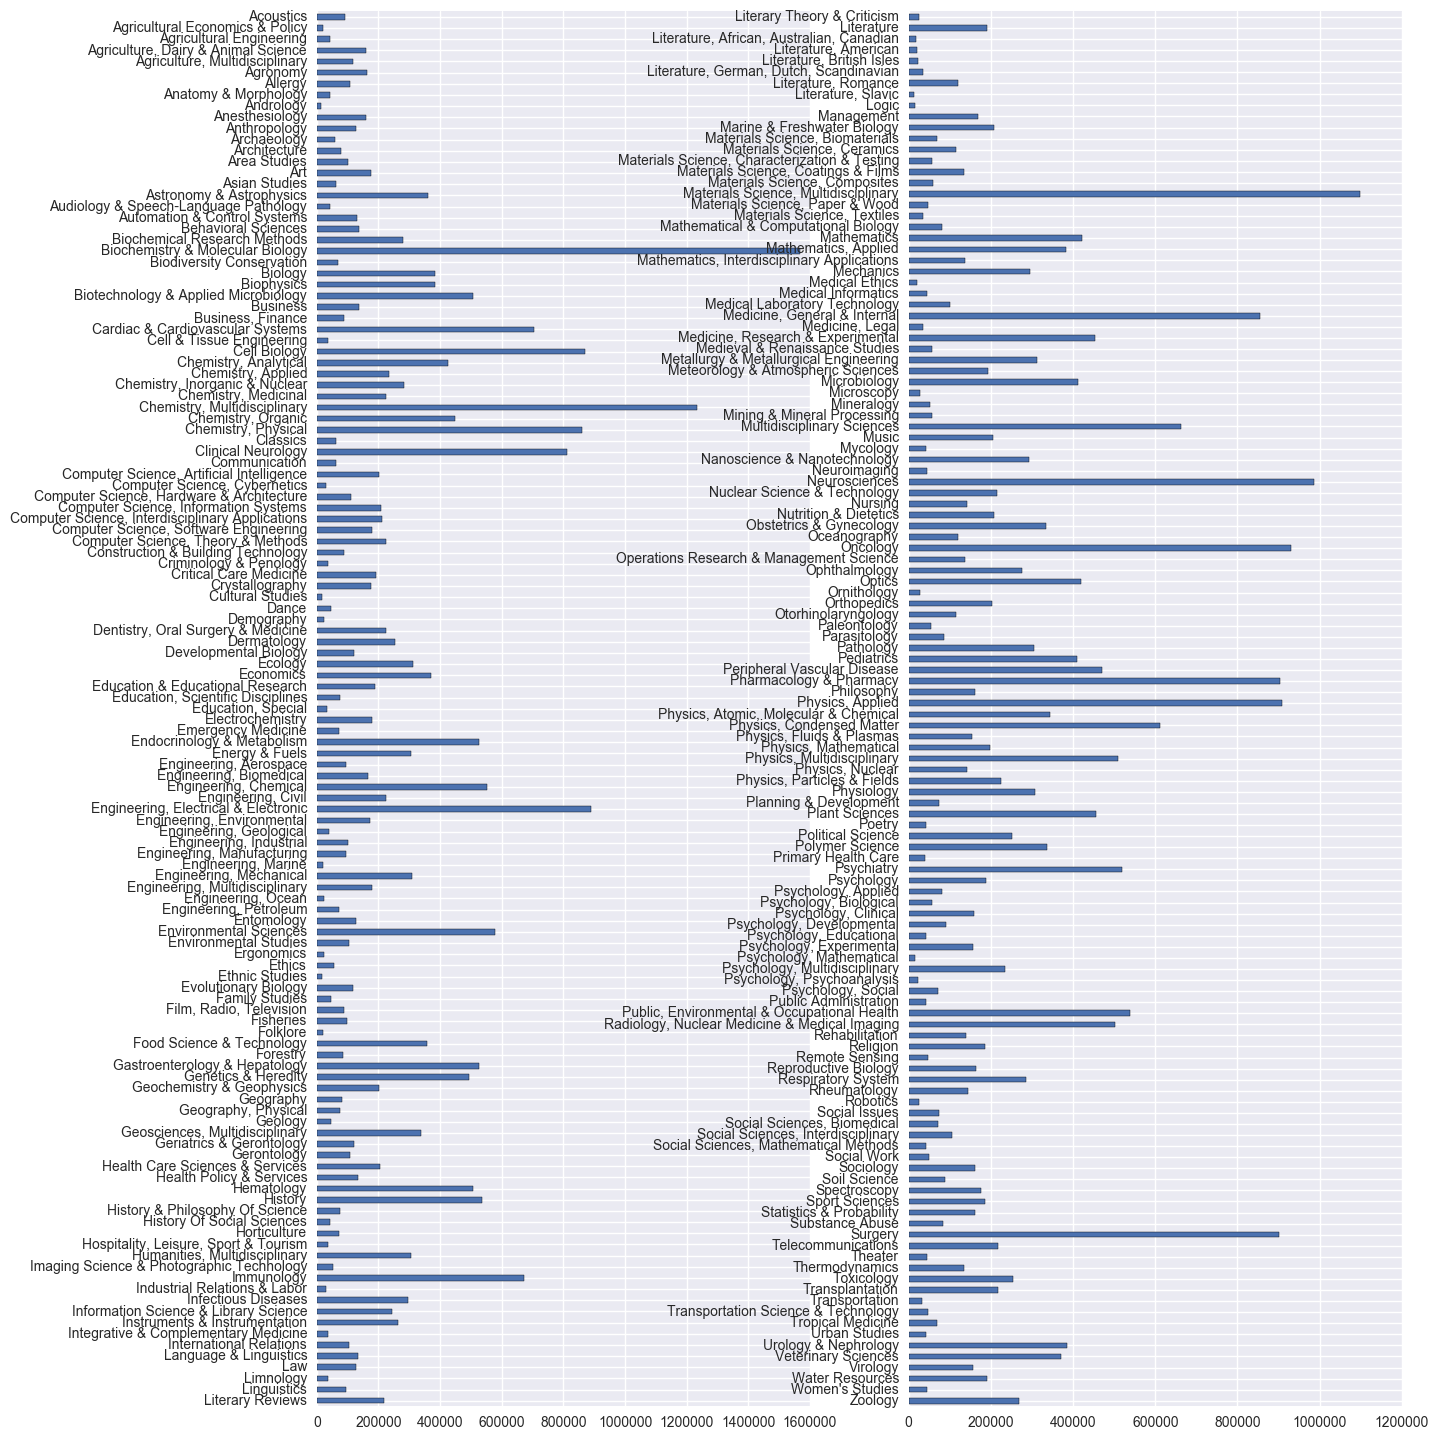

In [7]:
#just a big bar plot of the overall number of pubs for each field
fig,axes = plt.subplots(1,2,figsize=(14,18))
mx = cat_pubs_by_year.sum(0)[:-1].max()
cat_pubs_by_year.sum(0)[:125][::-1].plot(kind='barh',ax=axes[0],ylim=(0,mx))
cat_pubs_by_year.sum(0)[125:-1][::-1].plot(kind='barh',ax=axes[1],ylim=(0,mx));

In [8]:
def growth(cat,window):
    mx = len(cat_pubs_by_year)-(2*window-1)
    result = []
    for i in range(mx):
        a = cat_pubs_by_year[cat][i:i+window].sum()
        aprop = a/cat_pubs_by_year['ALL'][i:i+window].sum()
        b = cat_pubs_by_year[cat][i+window:i+window*2].sum()
        bprop = b/cat_pubs_by_year['ALL'][i+window:i+window*2].sum()
        result.append(np.log(bprop/aprop))    
    return np.array(result)

In [9]:
def parse_results(fi):
    df =  pd.read_table(fi,header=None,names=['measure','data'],index_col='measure')
    df.data = df.data.apply(lambda x: np.array(x.split(','),dtype=float))
    return df

In [16]:
colors = seaborn.color_palette()
def plotter(cat,window_size,mode='local'):
    #df = parse_results("{}by-cat-results/results_{}_{}".format(DATADIR,window_size,cat))
    df = parse_results("{}by-cat-results/{}_null/results_{}_{}".format(DATADIR,mode,window_size,cat))
    start = 1991+window_size-.5
    r = np.arange(start,start+len(df.ix['jsds'][0]))
    if window_size%2==0:
        r2 = np.arange(1991,1991+len(df.ix['ents'][0]))
    else:
        r2 = np.arange(start,start+len(df.ix['ents'][0]))

    fig,axes = plt.subplots(1,4,figsize=(16,4))
    
    ax = axes[0]
    ax.plot(r,df.ix['jsds'][0],label='JSD (raw)',color=colors[0])
    ax.plot(r,df.ix['ent_difs'][0],label=r'$\Delta H$ (raw)',color=colors[1])
    ax.plot(r,df.ix['jsd-null_m'][0],label='JSD (null)',c=colors[0],ls='--')
    ax.plot(r,df.ix['entdif-null_m'][0],label=r'$\Delta H$ (null)',color=colors[1],ls='--')
    #ax.fill_between(r,df.ix['entropy-null_m'][0]+df.ix['entropy-null_c'][0],df.ix['entropy-null_m'][0]-df.ix['entropy-null_c'][0],color=colors[1],alpha=.25)
    ax.axhline(0,c='k',ls='--')
    ax.set_xticks(np.arange(r[0]-.5,r[-1]+.5,5))
    ax.legend(loc='lower right',fontsize='medium')
    ax.set_title('Change measures')

    ax = axes[1]
    ax.plot(r2,df.ix['ents'][0],label='H (raw)')
    if mode == 'global':
        ax.plot(r2,df.ix['entropy-null_m'][0],label='H (null)',color=colors[1])
        ax.fill_between(r2,df.ix['entropy-null_m'][0]+df.ix['entropy-null_c'][0],df.ix['entropy-null_m'][0]-df.ix['entropy-null_c'][0],color=colors[1],alpha=.25)
    ax.set_title('Entropy')
    ax.legend(loc='lower right')
    
    ax = axes[2]
    ax.plot(r,growth(cat,window_size),label='Growth')
    ax.axhline(0,c='k',ls='--')
    ax.set_xticks(np.arange(r[0]-.5,r[-1]+.5,5))
    ax.set_title('Growth')
    
    ax = axes[3]
    ax.plot(r,df.ix['jsds'][0]-df.ix['jsd-null_m'][0],label='JSD (corrected)',color=colors[0])
    ax.plot(r,df.ix['ent_difs'][0]-df.ix['entdif-null_m'][0],label=r'$\Delta H$ (corrected)',color=colors[1])
    ax.legend(loc='upper right')
    ax.set_xticks(np.arange(r[0]-.5,r[-1]+.5,5))    
    ax.set_title('Corrected measures')
    
    fig.suptitle(cat)
    

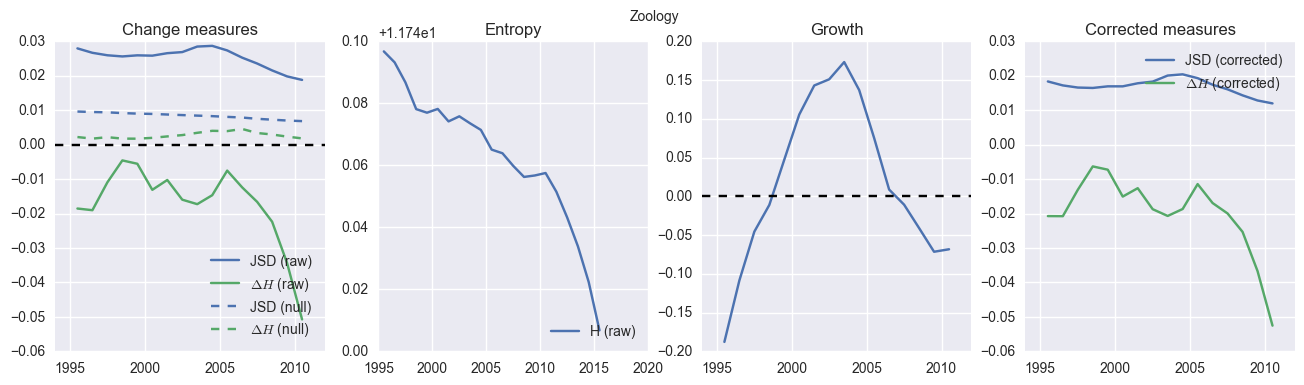

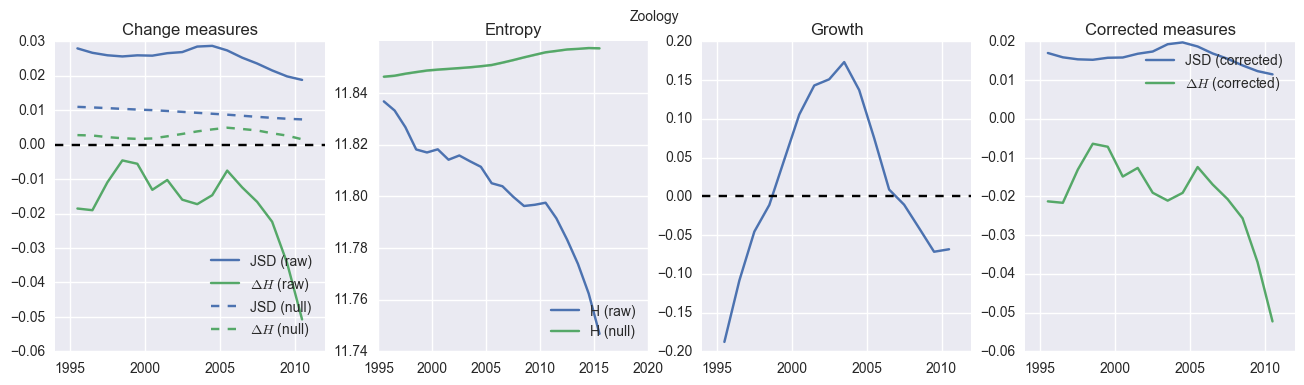

In [91]:
cat = 'Zoology'
win = 5
plotter(cat,win,'local')
plotter(cat,win,'global')

In [ ]:
ls ../results/

In [77]:
def normalize(arr):
    a = arr.copy()
    if a.min()<0:
        a += abs(a.min())
    a = a / a.max()
    return a

delta_h = []
g = []
for cat in tq(cats):
    df = parse_results("{}by-cat-results/results_{}_{}".format(DATADIR,window_size,cat))
    current_growth = np.mean(growth(cat,window_size))
    #if np.all(np.abs(current_growth)>0):
    delta_h += list(np.mean(df.ix['ent_difs'][0]-df.ix['entdif-null_m'][0]))
    g += list(current_growth)


TypeError: 'numpy.float64' object is not iterable

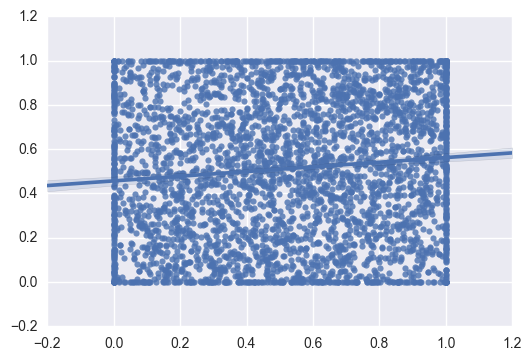

In [57]:
seaborn.regplot(x=np.array(delta_h),y=np.array(g))

In [64]:
cat_pubs_by_year['Literary Reviews'].sum()

217142.0

In [65]:
cat_pubs_by_year['Robotics'].sum()

25438.0